In [15]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm

import hddm
import kabuki
import arviz as az

import warnings
warnings.simplefilter(action="ignore", category=RuntimeWarning)
warnings.simplefilter(action="ignore", category=FutureWarning)

print("The current version of kabuki is: ", kabuki.__version__)
print("The current version of HDDM is: ", hddm.__version__)
print("The current version of arviz is: ", az.__version__)

The current version of kabuki is:  0.6.5RC4
The current version of HDDM is:  0.9.8RC
The current version of arviz is:  0.17.0


## RLHDDM

More detials please see [RLHDDM](https://hddm.readthedocs.io/en/latest/demo_RLHDDMtutorial.html)

Few things to note:
- Due to the RLHDDM cannot be serialized by pickle, so
  - RLHDDM cannot be sampling parallalelly.
  - RLHDDM cannot be saved. 
  - But the infdata can be saved.


## Fitting

### load data

In [2]:
data = hddm.load_csv(hddm.__path__[0] + "/examples/rlddm_data.csv")
data

,subj_idx,response,cond,rt,trial,split_by,feedback,q_init
0,42,0.0,CD,1.255,1.0,1,0.0,0.5
1,42,1.0,EF,0.778,1.0,2,0.0,0.5
2,42,1.0,AB,0.647,1.0,0,1.0,0.5
3,42,1.0,AB,0.750,2.0,0,1.0,0.5
4,42,0.0,EF,0.772,2.0,2,1.0,0.5
...,...,...,...,...,...,...,...,...
5275,80,1.0,CD,0.680,39.0,1,1.0,0.5
5276,80,1.0,AB,0.814,39.0,0,1.0,0.5
5277,80,1.0,EF,0.693,40.0,2,0.0,0.5
5278,80,1.0,CD,1.798,40.0,1,0.0,0.5


### define and fit models

In [3]:
nmcmc = 1500
n_burn = 500
n_chain = 4

In [4]:
%time
# set dual=True to model separate learning rates for positive and negative prediction errors.
rl = hddm.HDDMrl(data, dual=True, include=["a","v","t","z","alpha"])
# set sample and burn-in
rl_infdata = rl.sample(nmcmc, burn=n_burn, chains=n_chain, return_infdata=True,save_name="rl", parallel=False)

CPU times: user 13 µs, sys: 11 µs, total: 24 µs
Wall time: 48.9 µs
No model attribute --> setting up standard HDDM
Set model to ddm
 [-----------------100%-----------------] 1501 of 1500 complete in 214.6 sechddm sampling elpased time:  214.897 s
 [-----------------100%-----------------] 1501 of 1500 complete in 217.6 sechddm sampling elpased time:  217.903 s
 [-----------------100%-----------------] 1500 of 1500 complete in 217.0 sechddm sampling elpased time:  217.269 s
 [-----------------100%-----------------] 1501 of 1500 complete in 215.7 sechddm sampling elpased time:  215.92 s
hddm sampling elpased time:  882.169 s
Start converting to InferenceData...
fail to save model: cannot pickle 'pymc.LazyFunction.Counter' object


In [5]:
%time
# set dual=True to model separate learning rates for positive and negative prediction errors.
rl_dual = hddm.HDDMrl(data, dual=True, include=["a","v","t","z","alpha"])
# set sample and burn-in
rl_dual_infdata = rl_dual.sample(nmcmc, burn=n_burn, chains=n_chain, return_infdata=True,save_name="rl_dual", parallel=False)

CPU times: user 15 µs, sys: 1 µs, total: 16 µs
Wall time: 30.8 µs
No model attribute --> setting up standard HDDM
Set model to ddm
 [-----------------100%-----------------] 1501 of 1500 complete in 216.5 sechddm sampling elpased time:  216.734 s
 [-----------------100%-----------------] 1501 of 1500 complete in 215.8 sechddm sampling elpased time:  216.064 s
 [-----------------100%-----------------] 1501 of 1500 complete in 216.0 sechddm sampling elpased time:  216.241 s
 [-----------------100%-----------------] 1501 of 1500 complete in 215.7 sechddm sampling elpased time:  215.927 s
hddm sampling elpased time:  881.004 s
Start converting to InferenceData...
fail to save model: cannot pickle 'pymc.LazyFunction.Counter' object


In [6]:
# rl_dual = hddm.HDDMrl(data, dual=True, include=["a","v","t","z","alpha"])
# rl_dual = rl_dual.load_db("rl_dual.db", db="pickle")
# rl_dual_infdata = az.from_netcdf("rl_dual.nc")

## Diagnostic

In [7]:
az.summary(rl_dual_infdata, var_names = ['~subj', '~std'], filter_vars= 'regex')

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
a,1.827,0.079,1.680,1.976,0.001,0.001,2903.0,2630.0,1.00
v,3.807,0.450,2.965,4.664,0.010,0.007,1911.0,3199.0,1.00
t,0.431,0.044,0.349,0.511,0.001,0.001,1645.0,1756.0,1.00
z,0.478,0.007,0.465,0.491,0.000,0.000,533.0,1399.0,1.01
alpha,-4.354,0.717,-5.739,-3.057,0.025,0.018,840.0,1166.0,1.00
pos_alpha,-0.918,0.307,-1.531,-0.367,0.008,0.006,1475.0,2504.0,1.00


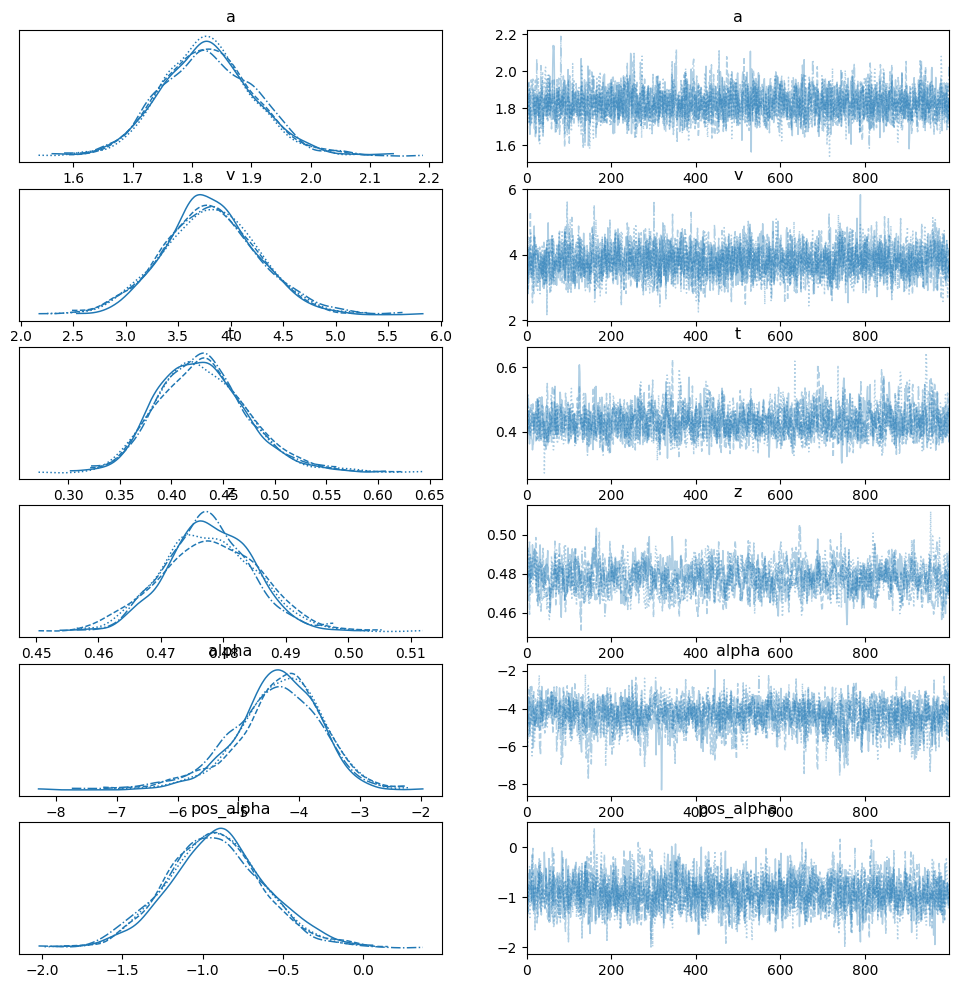

In [8]:
axes = az.plot_trace(rl_dual_infdata, var_names = ['~subj', '~std'], filter_vars= 'regex')

## Comparison

In [9]:
%time
rl_infdata = rl.to_infdata(loglike=True, save_name="rl", parallel=False)
rl_dual_infdata = rl_dual.to_infdata(loglike=True, save_name="rl_dual", parallel=False)

CPU times: user 37 µs, sys: 1e+03 ns, total: 38 µs
Wall time: 73.2 µs
Start converting to InferenceData...
 [-------------------110%-------------------] 31 of 28 complete in 32.8 secThe time of calculation of loglikelihood took 60.214 seconds
Start converting to InferenceData...
 [-------------------110%-------------------] 31 of 28 complete in 33.0 secThe time of calculation of loglikelihood took 59.188 seconds


In [10]:
compare_dict = {
    "Model 0 (RL)":rl_infdata,
    "Model 1 (RL with dual learning rate)":rl_dual_infdata,
}

az.compare(compare_dict, ic="waic")

,rank,elpd_waic,p_waic,elpd_diff,weight,se,dse,warning,scale
Model 0 (RL),0,-175777.296405,153427.75000,0.000000,0.5,20675.962814,0.000000,True,log
Model 1 (RL with dual learning rate),1,-179650.588284,157198.34375,3873.291879,0.5,22136.001953,3481.859699,True,log


## PPC

In [11]:
# create empty dataframe to store simulated data
sim_data = pd.DataFrame()
# create a column samp to be used to identify the simulated data sets
data["samp"] = 0
# get traces, note here we extract traces from rl_dual
traces = rl_dual.get_traces()
# decide how many times to repeat simulation process. repeating this multiple times is generally recommended as it better captures the uncertainty in the posterior distribution, but will also take some time
for i in tqdm(range(1, 51)):
    # randomly select a row in the traces to use for extracting parameter values
    sample = np.random.randint(0, traces.shape[0] - 1)
    # loop through all subjects in observed data
    for s in data.subj_idx.unique():
        # get number of trials for each condition.
        size0 = len(
            data[(data["subj_idx"] == s) & (data["split_by"] == 0)].trial.unique()
        )
        size1 = len(
            data[(data["subj_idx"] == s) & (data["split_by"] == 1)].trial.unique()
        )
        size2 = len(
            data[(data["subj_idx"] == s) & (data["split_by"] == 2)].trial.unique()
        )
        # set parameter values for simulation
        a = traces.loc[sample, "a_subj." + str(s)]
        t = traces.loc[sample, "t_subj." + str(s)]
        scaler = traces.loc[sample, "v_subj." + str(s)]
        # when generating data with two learning rates pos_alpha represents learning rate for positive prediction errors and alpha for negative prediction errors
        alphaInv = traces.loc[sample, "alpha_subj." + str(s)]
        pos_alphaInv = traces.loc[sample, "pos_alpha_subj." + str(s)]
        # NOTE: take inverse logit of estimated alpha and pos_alpha
        alpha = np.exp(alphaInv) / (1 + np.exp(alphaInv))
        pos_alpha = np.exp(pos_alphaInv) / (1 + np.exp(pos_alphaInv))
        # simulate data for each condition changing only values of size, p_upper, p_lower and split_by between conditions.
        sim_data0 = hddm.generate.gen_rand_rlddm_data(
            a=a,
            t=t,
            scaler=scaler,
            alpha=alpha,
            pos_alpha=pos_alpha,
            size=size0,
            p_upper=0.8,
            p_lower=0.2,
            split_by=0,
        )
        sim_data1 = hddm.generate.gen_rand_rlddm_data(
            a=a,
            t=t,
            scaler=scaler,
            alpha=alpha,
            pos_alpha=pos_alpha,
            size=size1,
            p_upper=0.7,
            p_lower=0.3,
            split_by=1,
        )
        sim_data2 = hddm.generate.gen_rand_rlddm_data(
            a=a,
            t=t,
            scaler=scaler,
            alpha=alpha,
            pos_alpha=pos_alpha,
            size=size2,
            p_upper=0.6,
            p_lower=0.4,
            split_by=2,
        )
        # append the conditions
        # sim_data0 = sim_data0.append([sim_data1, sim_data2], ignore_index=True)
        sim_data0 = pd.concat([sim_data0, sim_data1, sim_data2], axis=0, ignore_index=True)
        # assign subj_idx
        sim_data0["subj_idx"] = s
        # identify that these are simulated data
        sim_data0["type"] = "simulated"
        # identify the simulated data
        sim_data0["samp"] = i
        # append data from each subject
        # sim_data = sim_data.append(sim_data0, ignore_index=True)
        sim_data = pd.concat([sim_data, sim_data0], axis=0, ignore_index=True)
# combine observed and simulated data
ppc_dual_data = data[
    ["subj_idx", "response", "split_by", "rt", "trial", "feedback", "samp"]
].copy()
ppc_dual_data["type"] = "observed"
ppc_dual_sdata = sim_data[
    ["subj_idx", "response", "split_by", "rt", "trial", "feedback", "type", "samp"]
].copy()
# ppc_dual_data = ppc_dual_data.append(ppc_dual_sdata)
ppc_dual_data = pd.concat([ppc_dual_data, ppc_dual_sdata], axis=0, ignore_index=True)

100%|██████████| 50/50 [20:50<00:00, 25.00s/it]


In [12]:
import pymc
plot_ppc_dual_data = ppc_dual_data[ppc_dual_data.trial < 41].copy()

# bin trials to for smoother estimate of response proportion across learning
plot_ppc_dual_data["bin_trial"] = pd.cut(
    plot_ppc_dual_data.trial, 11, labels=np.linspace(0, 10, 11)
).astype("int64")
# calculate means for each sample
sums = (
    plot_ppc_dual_data.groupby(["bin_trial", "split_by", "samp", "type"])
    .mean()
    .reset_index()
)
# calculate the overall mean response across samples
ppc_dual_sim = sums.groupby(["bin_trial", "split_by", "type"]).mean().reset_index()
# initiate columns that will have the upper and lower bound of the hpd
ppc_dual_sim["upper_hpd"] = 0
ppc_dual_sim["lower_hpd"] = 0
for i in range(0, ppc_dual_sim.shape[0]):
    # calculate the hpd/hdi of the predicted mean responses across bin_trials
    hdi = pymc.utils.hpd(
        sums.response[
            (sums["bin_trial"] == ppc_dual_sim.bin_trial[i])
            & (sums["split_by"] == ppc_dual_sim.split_by[i])
            & (sums["type"] == ppc_dual_sim.type[i])
        ],
        alpha=0.1,
    )
    ppc_dual_sim.loc[i, "upper_hpd"] = hdi[1]
    ppc_dual_sim.loc[i, "lower_hpd"] = hdi[0]
# calculate error term as the distance from upper bound to mean
ppc_dual_sim["up_err"] = ppc_dual_sim["upper_hpd"] - ppc_dual_sim["response"]
ppc_dual_sim["low_err"] = ppc_dual_sim["response"] - ppc_dual_sim["lower_hpd"]
ppc_dual_sim["model"] = "RLDDM_dual_learning"

In [13]:
# bin trials to for smoother estimate of response proportion across learning
plot_ppc_dual_data["bin_trial"] = pd.cut(
    plot_ppc_dual_data.trial, 11, labels=np.linspace(0, 10, 11)
).astype("int64")
# calculate means for each sample
sums = (
    plot_ppc_dual_data.groupby(["bin_trial", "split_by", "samp", "type"])
    .mean()
    .reset_index()
)
# calculate the overall mean response across samples
ppc_dual_sim = sums.groupby(["bin_trial", "split_by", "type"]).mean().reset_index()
# initiate columns that will have the upper and lower bound of the hpd
ppc_dual_sim["upper_hpd"] = 0
ppc_dual_sim["lower_hpd"] = 0
for i in range(0, ppc_dual_sim.shape[0]):
    # calculate the hpd/hdi of the predicted mean responses across bin_trials
    hdi = pymc.utils.hpd(
        sums.response[
            (sums["bin_trial"] == ppc_dual_sim.bin_trial[i])
            & (sums["split_by"] == ppc_dual_sim.split_by[i])
            & (sums["type"] == ppc_dual_sim.type[i])
        ],
        alpha=0.1,
    )
    ppc_dual_sim.loc[i, "upper_hpd"] = hdi[1]
    ppc_dual_sim.loc[i, "lower_hpd"] = hdi[0]
# calculate error term as the distance from upper bound to mean
ppc_dual_sim["up_err"] = ppc_dual_sim["upper_hpd"] - ppc_dual_sim["response"]
ppc_dual_sim["low_err"] = ppc_dual_sim["response"] - ppc_dual_sim["lower_hpd"]
ppc_dual_sim["model"] = "RLDDM_dual_learning"

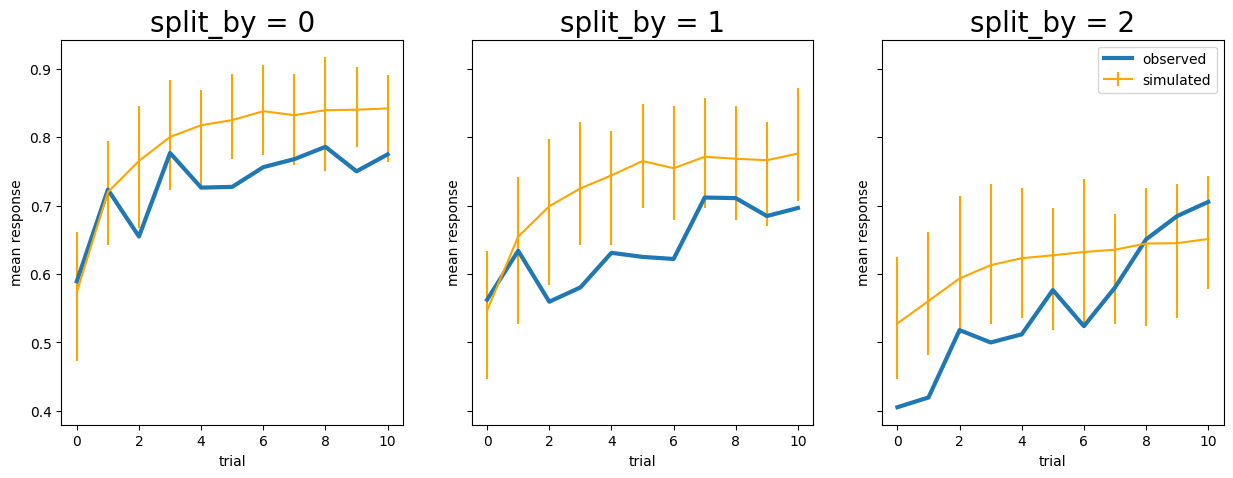

In [16]:
# plotting evolution of choice proportion for best option across learning for observed and simulated data.
fig, axs = plt.subplots(figsize=(15, 5), nrows=1, ncols=3, sharex=True, sharey=True)
for i in range(0, 3):
    ax = axs[i]
    d = ppc_dual_sim[(ppc_dual_sim.split_by == i) & (ppc_dual_sim.type == "simulated")]
    ax.errorbar(
        d.bin_trial,
        d.response,
        yerr=[d.low_err, d.up_err],
        label="simulated",
        color="orange",
    )
    d = ppc_dual_sim[(ppc_dual_sim.split_by == i) & (ppc_dual_sim.type == "observed")]
    ax.plot(d.bin_trial, d.response, linewidth=3, label="observed")
    ax.set_title("split_by = %i" % i, fontsize=20)
    ax.set_ylabel("mean response")
    ax.set_xlabel("trial")
plt.legend()